# 03-1 트랜스포머를 사용한 텍스트 분류

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/hm-dl/blob/main/03-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

## 셀프 어텐션

In [1]:
!pip install -U keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.1.1 which is incompatible.


In [2]:
import keras
from keras import layers

def self_attention(inputs, att_dims):
    # (n_batch, n_token, embed_dims) --> (n_batch, n_token, att_dims)
    query = layers.Dense(att_dims)(inputs)
    key = layers.Dense(att_dims)(inputs)
    value = layers.Dense(att_dims)(inputs)
    # score: (n_batch, n_token, n_token)
    key_t = keras.ops.transpose(k, axes=(0, 2, 1))
    query_key_dot = keras.ops.matmul(query, key_t) / keras.ops.sqrt(att_dims)
    score = keras.activations.softmax(query_key_dot)
    # (n_batch, n_token, att_dims)
    return keras.ops.matmul(score, value)

## 멀티 헤드 어텐션

In [3]:
inputs = keras.Input(shape=(10, 15))
x = layers.MultiHeadAttention(num_heads=4, key_dim=20)(query=inputs,
                                                       value=inputs)
model = keras.Model(inputs, x)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 10, 15)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 10, 15)         │          5,055 │ input_layer[0][0],     │
│ (MultiHeadAttention)      │                        │                │ input_layer[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,055 (19.75 KB)

 Trainable params: 5,055 (19.75 KB)

 Non-trainable params: 0 (0.00 B)

## 위치 인코딩

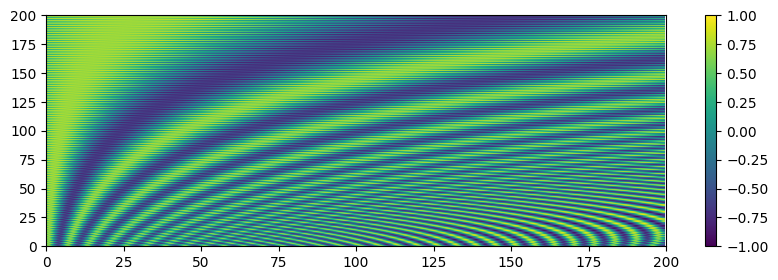

In [4]:
import numpy as np
import matplotlib.pyplot as plt

d = 500
n_token = 200
pos_encoding = np.zeros((d, n_token))
for p in range(n_token):
    for i in range(0, d, 2):
        pos_encoding[i, p] = np.sin(p/10000**(i/d))
        pos_encoding[i+1, p] = np.cos(p/10000**(i/d))
plt.figure(figsize=(10, 3))
plt.imshow(pos_encoding, interpolation="quadric", aspect="auto")
plt.axis([0, n_token, 0, 200])
plt.colorbar()
plt.show()

In [5]:
vocab_size = 10000
embed_dim = 768
max_seq_len = 512

inputs = keras.Input(shape=(None,))
token_embedding = layers.Embedding(vocab_size, embed_dim)(inputs)
token_pos = keras.ops.arange(n_token)
pos_embedding = layers.Embedding(max_seq_len, embed_dim)(token_pos)
encoder_inputs = token_embedding + pos_embedding

## 층 정규화

In [6]:
data = np.arange(12).reshape(2, 2, 3)
print(data)

[[[ 0  1  2]
  [ 3  4  5]]

 [[ 6  7  8]
  [ 9 10 11]]]


In [7]:
batchnorm = layers.BatchNormalization()
print(batchnorm(data, training=True).numpy())

[[[-1.3415811  -1.3415811  -1.3415811 ]
  [-0.44719368 -0.44719374 -0.44719374]]

 [[ 0.44719374  0.44719374  0.44719374]
  [ 1.3415811   1.341581    1.3415812 ]]]


In [8]:
temp = np.array([0, 3, 6, 9])
(temp - np.mean(temp)) / (np.sqrt(np.var(temp) + 1e-3))

array([-1.34158116, -0.44719372,  0.44719372,  1.34158116])

In [9]:
layernorm = layers.LayerNormalization()
print(layernorm(data).numpy())

[[[-1.2238274  0.         1.2238274]
  [-1.2238274  0.         1.2238274]]

 [[-1.2238274  0.         1.2238274]
  [-1.2238274  0.         1.2238274]]]


In [10]:
temp = np.array([0, 1, 2])
(temp - np.mean(temp)) / (np.sqrt(np.var(temp) + 1e-3))

array([-1.22382734,  0.        ,  1.22382734])

## 트랜스포머 인코더

In [11]:
# x는 토큰 임베딩과 위치 임베딩을 더한 값입니다.
def transformer_encoder(x, padding_mask, dropout):
    residual = x
    key_dim = embed_dim // num_heads
    # 멀티 헤드 어텐션을 통과합니다.
    x = layers.MultiHeadAttention(num_heads, key_dim, dropout=dropout)(
        query=x, value=x, attention_mask=padding_mask)
    x = layers.Dropout(dropout)(x)
    # 스킵 연결
    x = x + residual
    x = layers.LayerNormalization()(x)
    residual = x
    # 위치별 피드 포워드 네트워크
    x = layers.Dense(embed_dim * 4, activation='relu')(x)
    x = layers.Dense(embed_dim)(x)
    x = layers.Dropout(dropout)(x)
    # 스킵 연결
    x = x + residual
    x = layers.LayerNormalization()(x)
    return x

## BERT

In [12]:
!pip install -q keras-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.2/508.2 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 49.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatible.


In [13]:
import keras_nlp

# BERT 베이스
vocab_size = 28996
num_layers = 12
num_heads = 12
embed_dim = 768
dropout = 0.1
max_seq_len = 512

token_ids = keras.Input(shape=(None,))
segment_ids = keras.Input(shape=(None,))
padding_mask = keras.Input(shape=(None,))

token_embedding = layers.Embedding(vocab_size, embed_dim)(token_ids)
pos_embedding = keras_nlp.layers.PositionEmbedding(max_seq_len)(token_embedding)
seg_embedding = layers.Embedding(2, embed_dim)(segment_ids)

x = layers.Add()((token_embedding, pos_embedding, seg_embedding))
x = layers.LayerNormalization()(x)
x = layers.Dropout(dropout)(x)

for _ in range(num_layers):
    x = transformer_encoder(x, padding_mask, dropout)

outputs = layers.Dense(embed_dim, activation='tanh')(x[:,0,:])
model = keras.Model(inputs=(token_ids, segment_ids, padding_mask),
                    outputs=(outputs))
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, None, 768)      │     22,268,928 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ position_embedding        │ (None, None, 768)      │        393,216 │ embedding_2[0][0]      │
│ (PositionEmbedding)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, None, 768)      │          1,536 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, None, 768)      │              0 │ embedding_2[0][0],     │
│                           │                        │                │ position_embedding[0]… │
│                           │                        │                │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, None, 768)      │          1,536 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, None, 768)      │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, None, 768)      │      2,362,368 │ input_layer_4[0][0],   │
│ (MultiHeadAttention)      │                        │                │ dropout_1[0][0],       │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, None, 768)      │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, None, 768)      │              0 │ dropout_3[0][0],       │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, None, 768)      │          1,536 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 3072)     │      2,362,368 │ layer_normalization_2… │
├──────────────────────

 Total params: 108,310,272 (413.17 MB)

 Trainable params: 108,310,272 (413.17 MB)

 Non-trainable params: 0 (0.00 B)

## KerasNLP를 사용한 전이 학습

In [14]:
import tensorflow_datasets as tfds

(train_ds, test_ds), ds_info = tfds.load("imdb_reviews",
                                         split=["train", "test"],
                                         with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteH55B2O/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteH55B2O/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteH55B2O/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [15]:
ds_info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir=PosixGPath('/tmp/tmpp4emkmaltfds'),
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
        'train': <SplitInfo

In [16]:
for x in train_ds.take(5):
    print(x['text'].numpy()[:70], x['label'].numpy())

b"This was an absolutely terrible movie. Don't be lured in by Christophe" 0
b'I have been known to fall asleep during films, but this is usually due' 0
b'Mann photographs the Alberta Rocky Mountains in a superb fashion, and ' 0
b'This is the kind of film for a snowy Sunday afternoon when the rest of' 1
b'As others have mentioned, all the women that go nude in this film are ' 1


In [17]:
!pip install -U tensorflow-text

In [18]:
classifier = keras_nlp.models.BertClassifier.from_preset(
    "bert_base_en",
    num_classes=2
)

100%|██████████| 510/510 [00:00<00:00, 832kB/s]
100%|██████████| 414M/414M [00:22<00:00, 19.0MB/s]
100%|██████████| 548/548 [00:00<00:00, 440kB/s]


TypeError: <class 'keras_nlp.src.models.bert.bert_tokenizer.BertTokenizer'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras_nlp.src.models.bert.bert_tokenizer', 'class_name': 'BertTokenizer', 'config': {'name': 'bert_tokenizer', 'trainable': True, 'dtype': 'int32', 'vocabulary': None, 'sequence_length': None, 'lowercase': False, 'strip_accents': False, 'split': True, 'suffix_indicator': '##', 'oov_token': '[UNK]'}, 'registered_name': 'keras_nlp>BertTokenizer', 'assets': ['assets/tokenizer/vocabulary.txt'], 'weights': None}.

Exception encountered: Error when deserializing class 'BertTokenizer' using config={'name': 'bert_tokenizer', 'trainable': True, 'dtype': 'int32', 'vocabulary': None, 'sequence_length': None, 'lowercase': False, 'strip_accents': False, 'split': True, 'suffix_indicator': '##', 'oov_token': '[UNK]'}.

Exception encountered: BertTokenizer requires the `tensorflow-text` package. Please install with `pip install tensorflow-text`.

In [ ]:
classifier.backbone.trainable = False

In [24]:
classifier.fit(train_input, train_target)

ValueError: Can't convert non-rectangular Python sequence to Tensor.

In [ ]:
classifier.preprocessor(features)

{'token_ids': <tf.Tensor: shape=(2, 512), dtype=int32, numpy=
 array([[ 101, 1109, 3613, ...,    0,    0,    0],
        [ 101,  146, 9424, ...,    0,    0,    0]], dtype=int32)>,
 'segment_ids': <tf.Tensor: shape=(2, 512), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>,
 'padding_mask': <tf.Tensor: shape=(2, 512), dtype=bool, numpy=
 array([[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]])>}

In [ ]:
classifier.preprocessor(features)['token_ids'].numpy()[0, :100]

array([  101,  1109,  3613,  3058, 17594,  4874,   119,   102,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int32)

In [ ]:
classifier.preprocessor(features)['padding_mask'].numpy()[0, :100]

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [ ]:
classifier.preprocessor(features)['segment_ids'].numpy()[0, :100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
features = ["The quick brown fox jumped.", "I forgot my homework."]
labels = [0, 3]

classifier.fit(x=features, y=labels, batch_size=2)

KeyboardInterrupt: 

In [ ]:
classifier.backbone.summary()